In this kernel I'm working with data from Google Cloud & NCAA® ML Competition 2019-Men's Challenge. We'll try to predict winners of NCAA based on previous tournaments! We have a lot of data, so let's start with EDA and then build a baseline model.

![](https://i.imgur.com/jEDyzuA.png)

## Import libraries

In [1]:
# Libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import copy
import datetime
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import xgboost as xgb
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, classification_report, confusion_matrix
import json
import ast
import time
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

import os
import glob

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Helper functions and classes

In [2]:
class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'])

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)

In [3]:
class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            pass
        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

        self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
                         or 'attempt' in col]

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)

In [4]:
class ClassifierModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='auc',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """
        self.cols_to_drop = cols_to_drop

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1 if len(set(y.values)) == 2 else len(set(y.values))
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)
            # y = X['accuracy_group']

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict_proba(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(float)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
#             print(classification_report(y, self.oof.argmax(1)))
            print(classification_report(y, (self.oof > 0.5) * 1))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=25)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            g = sns.heatmap(confusion_matrix(y, (self.oof > 0.5) * 1), annot=True, cmap=plt.cm.Blues,fmt="d")
            g.set(ylim=(-0.5, 4), xlim=(-0.5, 4), title='Confusion matrix')

            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.xticks(range(self.n_target), range(self.n_target))
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]
            self.cols_to_drop = cols_to_drop
            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
        print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
            print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)
            if self.cols_to_drop:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict_proba(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        full_evals_results[self.eval_metric] = np.abs(full_evals_results[self.eval_metric])
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

## Loading the data

Let's load all useful data into a single dictionary!

In [5]:
data_dict = {}
# for i in glob.glob('/kaggle/input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/*'):
for i in glob.glob('../M/input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/*.csv'):
    name = i.split('/')[-1].split('.')[0]
    if name != 'MTeamSpellings':
        data_dict[name] = pd.read_csv(i)
    else:
        data_dict[name] = pd.read_csv(i, encoding='cp1252')

## Data overview

In [6]:
data_dict.keys()

dict_keys(['MNCAATourneyDetailedResults', 'MNCAATourneyCompactResults', 'MSeasons', 'MRegularSeasonDetailedResults', 'MNCAATourneySlots', 'MGameCities', 'MConferenceTourneyGames', 'Cities', 'MRegularSeasonCompactResults', 'MNCAATourneySeedRoundSlots', 'MTeamConferences', 'MTeamCoaches', 'MMasseyOrdinals', 'Conferences', 'MTeams', 'MNCAATourneySeeds', 'MSecondaryTourneyTeams', 'MTeamSpellings', 'MSecondaryTourneyCompactResults'])

We have a lot of data, but I'll use only some of it in my baseline.

In [7]:
data_dict['MNCAATourneySeeds'].head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


Here we can see seeds of all the teams in all seasons.

In [8]:
data_dict['MNCAATourneyCompactResults'].head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


Here we can see pairs of teams which played in tournaments.

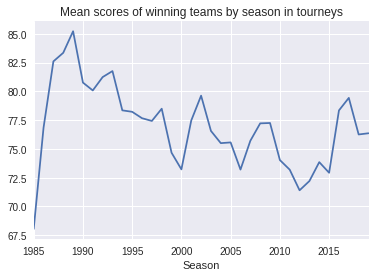

In [9]:
data_dict['MNCAATourneyCompactResults'].groupby(['Season'])['WScore'].mean().plot(kind='line');
plt.title('Mean scores of winning teams by season in tourneys');

We can see that mean scores peaked in ~1900 and steadily decreased since that time, but in recent years mean scores rise again. Sadly, I don't know enough info about history of matches in NCAA, but maybe teams prefer to pay more attention to defence now?

In [10]:
data_dict['MRegularSeasonCompactResults']

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
...,...,...,...,...,...,...,...,...
161547,2019,132,1153,69,1222,57,N,0
161548,2019,132,1209,73,1426,64,N,0
161549,2019,132,1277,65,1276,60,N,0
161550,2019,132,1387,55,1382,53,N,0


And here we can see the results of regular seasons.

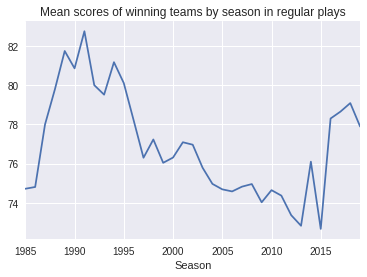

In [11]:
data_dict['MRegularSeasonCompactResults'].groupby(['Season'])['WScore'].mean().plot();
plt.title('Mean scores of winning teams by season in regular plays');

## Data processing and feature engineering.

The main idea is to extract features, which could be useful to understand how much one team is better than another one.

In [9]:
# process seed
data_dict['MNCAATourneySeeds']['Seed'] = data_dict['MNCAATourneySeeds']['Seed'].apply(lambda x: int(x[1:3]))
# take only useful columns
data_dict['MNCAATourneySeeds'] = data_dict['MNCAATourneySeeds'][['Season', 'TeamID', 'Seed']]
data_dict['MNCAATourneyCompactResults'] = data_dict['MNCAATourneyCompactResults'][['Season','WTeamID', 'LTeamID']]

# merge the data and rename the columns
df = pd.merge(data_dict['MNCAATourneyCompactResults'], data_dict['MNCAATourneySeeds'],
              how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'])
df = pd.merge(df, data_dict['MNCAATourneySeeds'], how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'])
df = df.drop(['TeamID_x', 'TeamID_y'], axis=1)
df.columns = ['Season', 'WTeamID', 'LTeamID', 'WSeed', 'LSeed']
df.head()

,Season,WTeamID,LTeamID,WSeed,LSeed
0,1985,1116,1234,9,8
1,1985,1120,1345,11,6
2,1985,1207,1250,1,16
3,1985,1229,1425,9,8
4,1985,1242,1325,3,14


In [13]:
team_win_score = data_dict['MRegularSeasonCompactResults'].groupby(['Season', 'WTeamID']).agg({'WScore':['sum', 'count']}).reset_index()
team_win_score.columns = ['Season', 'WTeamID', 'WScore_sum', 'WScore_count']
team_loss_score = data_dict['MRegularSeasonCompactResults'].groupby(['Season', 'LTeamID']).agg({'LScore':['sum', 'count']}).reset_index()
team_loss_score.columns = ['Season', 'LTeamID', 'LScore_sum', 'LScore_count']
df = pd.merge(df, team_win_score, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'WTeamID'])
df = pd.merge(df, team_loss_score, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, team_loss_score, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'LTeamID'])
df = pd.merge(df, team_win_score, how='left', left_on=['Season', 'LTeamID_x'], right_on=['Season', 'WTeamID'])
df.drop(['LTeamID_y', 'WTeamID_y'], axis=1, inplace=True)
df.head()

,Season,WTeamID_x,LTeamID_x,WSeed,LSeed,WScore_sum_x,WScore_count_x,LScore_sum_x,LScore_count_x,LScore_sum_y,LScore_count_y,WScore_sum_y,WScore_count_y
0,1985,1116,1234,9,8,1448,21,567.0,10.0,708.0,12.0,1525,20
1,1985,1120,1345,11,6,1308,18,537.0,8.0,732.0,11.0,1191,17
2,1985,1207,1250,1,16,1917,25,1085.0,18.0,128.0,2.0,822,11
3,1985,1229,1425,9,8,1484,20,529.0,9.0,449.0,7.0,1386,19
4,1985,1242,1325,3,14,1809,23,475.0,7.0,472.0,7.0,1349,20


In [16]:
df['x_score'] = df['WScore_sum_x'] + df['LScore_sum_y']
df['y_score'] = df['WScore_sum_y'] + df['LScore_sum_x']
df['x_count'] = df['WScore_count_x'] + df['LScore_count_y']
df['y_count'] = df['WScore_count_y'] + df['LScore_count_x']

In [19]:
df_win = df.copy()
df_los = df.copy()
df_win = df_win[['WSeed', 'LSeed', 'x_score', 'y_score', 'x_count', 'y_count']]
df_los = df_los[['LSeed', 'WSeed', 'y_score', 'x_score', 'y_count', 'x_count']]
df_win.columns = ['Seed_1', 'Seed_2', 'Score_1', 'Score_2', 'Count_1', 'Count_2']
df_los.columns = ['Seed_1', 'Seed_2', 'Score_1', 'Score_2', 'Count_1', 'Count_2']

In [20]:
df_win['Seed_diff'] = df_win['Seed_1'] - df_win['Seed_2']
df_win['Score_diff'] = df_win['Score_1'] - df_win['Score_2']
df_los['Seed_diff'] = df_los['Seed_1'] - df_los['Seed_2']
df_los['Score_diff'] = df_los['Score_1'] - df_los['Score_2']

df_win['Count_diff'] = df_win['Count_1'] - df_win['Count_2']
df_win['Mean_score1'] = df_win['Score_1'] / df_win['Count_1']
df_win['Mean_score2'] = df_win['Score_2'] / df_win['Count_2']
df_win['Mean_score_diff'] = df_win['Mean_score1'] - df_win['Mean_score2']
df_los['Count_diff'] = df_los['Count_1'] - df_los['Count_2']
df_los['Mean_score1'] = df_los['Score_1'] / df_los['Count_1']
df_los['Mean_score2'] = df_los['Score_2'] / df_los['Count_2']
df_los['Mean_score_diff'] = df_los['Mean_score1'] - df_los['Mean_score2']

In [21]:
df_win['result'] = 1
df_los['result'] = 0
data = pd.concat((df_win, df_los)).reset_index(drop=True)

In [22]:
for col in ['Score_1', 'Score_2', 'Count_1', 'Count_2', 'Score_diff', 'Count_diff']:
    print(col)
    data[col] = data[col].fillna(0).astype(int)

Score_1
Score_2
Count_1
Count_2
Score_diff
Count_diff


In [23]:
data.head()

,Seed_1,Seed_2,Score_1,Score_2,Count_1,Count_2,Seed_diff,Score_diff,Count_diff,Mean_score1,Mean_score2,Mean_score_diff,result
0,9,8,2156,2092,33,30,1,64,3,65.333333,69.733333,-4.400000,1
1,11,6,2040,1728,29,25,5,312,4,70.344828,69.120000,1.224828,1
2,1,16,2045,1907,27,29,-15,138,-2,75.740741,65.758621,9.982120,1
3,9,8,1933,1915,27,28,1,18,-1,71.592593,68.392857,3.199735,1
4,3,14,2281,1824,30,27,-11,457,3,76.033333,67.555556,8.477778,1


In [24]:
data.tail()

,Seed_1,Seed_2,Score_1,Score_2,Count_1,Count_2,Seed_diff,Score_diff,Count_diff,Mean_score1,Mean_score2,Mean_score_diff,result
4497,2,5,2532,2682,33,34,-3,-150,-1,76.727273,78.882353,-2.155080,0
4498,1,2,2839,2680,34,34,-1,159,0,83.500000,78.823529,4.676471,0
4499,2,3,2680,2339,34,32,-1,341,2,78.823529,73.093750,5.729779,0
4500,5,1,2682,2299,34,32,4,383,2,78.882353,71.843750,7.038603,0
4501,3,1,2339,2299,32,32,2,40,0,73.093750,71.843750,1.250000,0


## Training model

In [34]:
n_fold = 5
folds = RepeatedStratifiedKFold(n_splits=n_fold)
# folds = StratifiedKFold(n_splits=n_fold)

In [35]:
X = data.drop(['result'], axis=1)
y = data['result']

Fold 1 started at Thu Feb 20 17:47:32 2020
Training until validation scores don't improve for 10000 rounds
[1000]	train's binary_logloss: 0.447618	valid's binary_logloss: 0.564629
[2000]	train's binary_logloss: 0.38667	valid's binary_logloss: 0.575078
[3000]	train's binary_logloss: 0.342518	valid's binary_logloss: 0.589409
[4000]	train's binary_logloss: 0.306981	valid's binary_logloss: 0.604218
[5000]	train's binary_logloss: 0.277587	valid's binary_logloss: 0.617279
[6000]	train's binary_logloss: 0.25225	valid's binary_logloss: 0.630533
[7000]	train's binary_logloss: 0.229907	valid's binary_logloss: 0.643726
[8000]	train's binary_logloss: 0.210533	valid's binary_logloss: 0.657201
[9000]	train's binary_logloss: 0.193139	valid's binary_logloss: 0.670995
[10000]	train's binary_logloss: 0.177932	valid's binary_logloss: 0.681941
Did not meet early stopping. Best iteration is:
[10000]	train's binary_logloss: 0.177932	valid's binary_logloss: 0.681941
Fold 2 started at Thu Feb 20 17:47:53 2020

[7000]	train's binary_logloss: 0.230607	valid's binary_logloss: 0.627646
[8000]	train's binary_logloss: 0.210967	valid's binary_logloss: 0.639608
[9000]	train's binary_logloss: 0.193745	valid's binary_logloss: 0.650598
[10000]	train's binary_logloss: 0.178282	valid's binary_logloss: 0.662324
Did not meet early stopping. Best iteration is:
[10000]	train's binary_logloss: 0.178282	valid's binary_logloss: 0.662324
Fold 10 started at Thu Feb 20 17:51:24 2020
Training until validation scores don't improve for 10000 rounds
[1000]	train's binary_logloss: 0.444932	valid's binary_logloss: 0.5713
[2000]	train's binary_logloss: 0.38376	valid's binary_logloss: 0.587401
[3000]	train's binary_logloss: 0.338893	valid's binary_logloss: 0.600456
[4000]	train's binary_logloss: 0.303593	valid's binary_logloss: 0.615124
[5000]	train's binary_logloss: 0.273642	valid's binary_logloss: 0.629233
[6000]	train's binary_logloss: 0.247977	valid's binary_logloss: 0.643492
[7000]	train's binary_logloss: 0.225406	va

[2000]	train's binary_logloss: 0.38889	valid's binary_logloss: 0.566997
[3000]	train's binary_logloss: 0.343677	valid's binary_logloss: 0.582469
[4000]	train's binary_logloss: 0.308088	valid's binary_logloss: 0.595699
[5000]	train's binary_logloss: 0.278743	valid's binary_logloss: 0.60706
[6000]	train's binary_logloss: 0.253321	valid's binary_logloss: 0.617849
[7000]	train's binary_logloss: 0.231118	valid's binary_logloss: 0.628729
[8000]	train's binary_logloss: 0.211668	valid's binary_logloss: 0.639315
[9000]	train's binary_logloss: 0.194403	valid's binary_logloss: 0.649912
[10000]	train's binary_logloss: 0.179142	valid's binary_logloss: 0.661254
Did not meet early stopping. Best iteration is:
[10000]	train's binary_logloss: 0.179142	valid's binary_logloss: 0.661254
Fold 19 started at Thu Feb 20 17:56:21 2020
Training until validation scores don't improve for 10000 rounds
[1000]	train's binary_logloss: 0.448027	valid's binary_logloss: 0.563009
[2000]	train's binary_logloss: 0.387433	v

[10000]	train's binary_logloss: 0.188809	valid's binary_logloss: 0.628262
Did not meet early stopping. Best iteration is:
[10000]	train's binary_logloss: 0.188809	valid's binary_logloss: 0.628262
Fold 27 started at Thu Feb 20 18:00:45 2020
Training until validation scores don't improve for 10000 rounds
[1000]	train's binary_logloss: 0.446601	valid's binary_logloss: 0.57255
[2000]	train's binary_logloss: 0.385757	valid's binary_logloss: 0.595664
[3000]	train's binary_logloss: 0.341282	valid's binary_logloss: 0.613963
[4000]	train's binary_logloss: 0.305701	valid's binary_logloss: 0.628502
[5000]	train's binary_logloss: 0.275923	valid's binary_logloss: 0.643461
[6000]	train's binary_logloss: 0.250557	valid's binary_logloss: 0.658469
[7000]	train's binary_logloss: 0.228457	valid's binary_logloss: 0.672282
[8000]	train's binary_logloss: 0.209191	valid's binary_logloss: 0.685706
[9000]	train's binary_logloss: 0.192172	valid's binary_logloss: 0.698713
[10000]	train's binary_logloss: 0.17699	

[4000]	train's binary_logloss: 0.308992	valid's binary_logloss: 0.598222
[5000]	train's binary_logloss: 0.279289	valid's binary_logloss: 0.612125
[6000]	train's binary_logloss: 0.253806	valid's binary_logloss: 0.624992
[7000]	train's binary_logloss: 0.231229	valid's binary_logloss: 0.636824
[8000]	train's binary_logloss: 0.211631	valid's binary_logloss: 0.649464
[9000]	train's binary_logloss: 0.194206	valid's binary_logloss: 0.661749
[10000]	train's binary_logloss: 0.178536	valid's binary_logloss: 0.674165
Did not meet early stopping. Best iteration is:
[10000]	train's binary_logloss: 0.178536	valid's binary_logloss: 0.674165
Fold 36 started at Thu Feb 20 18:05:31 2020
Training until validation scores don't improve for 10000 rounds
[1000]	train's binary_logloss: 0.451769	valid's binary_logloss: 0.551338
[2000]	train's binary_logloss: 0.392917	valid's binary_logloss: 0.565049
[3000]	train's binary_logloss: 0.348374	valid's binary_logloss: 0.577866
[4000]	train's binary_logloss: 0.312645

Fold 44 started at Thu Feb 20 18:10:09 2020
Training until validation scores don't improve for 10000 rounds
[1000]	train's binary_logloss: 0.44618	valid's binary_logloss: 0.572824
[2000]	train's binary_logloss: 0.384439	valid's binary_logloss: 0.591429
[3000]	train's binary_logloss: 0.338814	valid's binary_logloss: 0.607848
[4000]	train's binary_logloss: 0.302832	valid's binary_logloss: 0.623643
[5000]	train's binary_logloss: 0.273004	valid's binary_logloss: 0.638764
[6000]	train's binary_logloss: 0.24757	valid's binary_logloss: 0.653069
[7000]	train's binary_logloss: 0.225256	valid's binary_logloss: 0.666531
[8000]	train's binary_logloss: 0.205946	valid's binary_logloss: 0.68001
[9000]	train's binary_logloss: 0.189005	valid's binary_logloss: 0.692656
[10000]	train's binary_logloss: 0.173759	valid's binary_logloss: 0.705744
Did not meet early stopping. Best iteration is:
[10000]	train's binary_logloss: 0.173759	valid's binary_logloss: 0.705744
Fold 45 started at Thu Feb 20 18:11:01 202

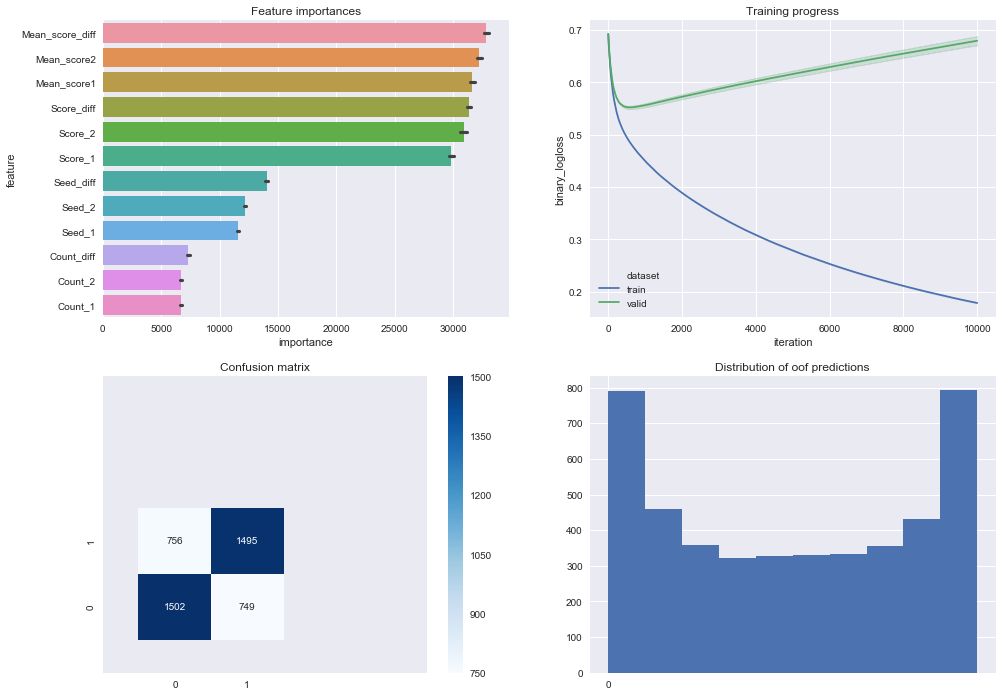

In [36]:
# some of params are from this kernel: https://www.kaggle.com/ratan123/march-madness-2020-ncaam-simple-lightgbm-on-kfold
param = {'n_estimators':10000,
          'num_leaves': 400,
          'min_child_weight': 0.034,
          'feature_fraction': 0.379,
          'bagging_fraction': 0.418,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.0068,
          "boosting_type": "gbdt",
          #"bagging_seed": 11,
          "metric": 'binary_logloss',
          "verbosity": 10,
          'reg_alpha': 0.3899,
          'reg_lambda': 0.648,
          'random_state': 47,
          'task':'train', 'nthread':-1, 
         'verbose': 1000,
         'early_stopping_rounds': 10000,
         'eval_metric': 'binary_logloss'
         }
cat_cols = []
mt = MainTransformer(create_interactions=False)
# ct = CategoricalTransformer(drop_original=True, cat_cols=cat_cols)
ft = FeatureTransformer()
transformers = {'ft': ft}
lgb_model = ClassifierModel(model_wrapper=LGBWrapper())
lgb_model.fit(X=X, y=y, folds=folds, params=param, preprocesser=mt, transformers=transformers,
                    eval_metric='binary_logloss', cols_to_drop=None, plot=True)

## Preparing test data

In [38]:
test = pd.read_csv('../M/input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
test = test.drop(['Pred'], axis=1)
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['Team1'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['Team2'] = test['ID'].apply(lambda x: int(x.split('_')[2]))
test = pd.merge(test, data_dict['MNCAATourneySeeds'], how='left', left_on=['Season', 'Team1'], right_on=['Season', 'TeamID'])
test = pd.merge(test, data_dict['MNCAATourneySeeds'], how='left', left_on=['Season', 'Team2'], right_on=['Season', 'TeamID'])
test = pd.merge(test, team_win_score, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'WTeamID'])
test = pd.merge(test, team_loss_score, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'LTeamID'])
test = pd.merge(test, team_loss_score, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'LTeamID'])
test = pd.merge(test, team_win_score, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'WTeamID'])
test['seed_diff'] = test['Seed_x'] - test['Seed_y']

In [39]:
test['x_score'] = test['WScore_sum_x'] + test['LScore_sum_y']
test['y_score'] = test['WScore_sum_y'] + test['LScore_sum_x']
test['x_count'] = test['WScore_count_x'] + test['LScore_count_y']
test['y_count'] = test['WScore_count_y'] + test['WScore_count_x']

In [40]:
test.head()

,ID,Season,Team1,Team2,TeamID_x,Seed_x,TeamID_y,Seed_y,WTeamID_x,WScore_sum_x,WScore_count_x,LTeamID_x,LScore_sum_x,LScore_count_x,LTeamID_y,LScore_sum_y,LScore_count_y,WTeamID_y,WScore_sum_y,WScore_count_y,seed_diff,x_score,y_score,x_count,y_count
0,2015_1107_1112,2015,1107,1112,1107,14,1112,2,1107,1627,24,1112.0,201.0,3.0,1107.0,469.0,8.0,1112,2398,31,12,2096.0,2599.0,32.0,55
1,2015_1107_1116,2015,1107,1116,1107,14,1116,5,1107,1627,24,1116.0,557.0,8.0,1107.0,469.0,8.0,1116,2096,26,9,2096.0,2653.0,32.0,50
2,2015_1107_1124,2015,1107,1124,1107,14,1124,3,1107,1627,24,1124.0,526.0,9.0,1107.0,469.0,8.0,1124,1686,23,11,2096.0,2212.0,32.0,47
3,2015_1107_1125,2015,1107,1125,1107,14,1125,15,1107,1627,24,1125.0,670.0,10.0,1107.0,469.0,8.0,1125,1617,21,-1,2096.0,2287.0,32.0,45
4,2015_1107_1129,2015,1107,1129,1107,14,1129,11,1107,1627,24,1129.0,463.0,8.0,1107.0,469.0,8.0,1129,1703,23,3,2096.0,2166.0,32.0,47


In [41]:
test = test[['Seed_x', 'Seed_y', 'x_score', 'y_score', 'x_count', 'y_count']]
test.columns = ['Seed_1', 'Seed_2', 'Score_1', 'Score_2', 'Count_1', 'Count_2']

In [42]:
test['Seed_diff'] = test['Seed_1'] - test['Seed_2']
test['Score_diff'] = test['Score_1'] - test['Score_2']
test['Seed_diff'] = test['Seed_1'] - test['Seed_2']
test['Score_diff'] = test['Score_1'] - test['Score_2']

test['Count_diff'] = test['Count_1'] - test['Count_2']
test['Mean_score1'] = test['Score_1'] / test['Count_1']
test['Mean_score2'] = test['Score_2'] / test['Count_2']
test['Mean_score_diff'] = test['Mean_score1'] - test['Mean_score2']
test['Count_diff'] = test['Count_1'] - test['Count_2']
test['Mean_score1'] = test['Score_1'] / test['Count_1']
test['Mean_score2'] = test['Score_2'] / test['Count_2']
test['Mean_score_diff'] = test['Mean_score1'] - test['Mean_score2']

In [43]:
test.head()

,Seed_1,Seed_2,Score_1,Score_2,Count_1,Count_2,Seed_diff,Score_diff,Count_diff,Mean_score1,Mean_score2,Mean_score_diff
0,14,2,2096.0,2599.0,32.0,55,12,-503.0,-23.0,65.5,47.254545,18.245455
1,14,5,2096.0,2653.0,32.0,50,9,-557.0,-18.0,65.5,53.060000,12.440000
2,14,3,2096.0,2212.0,32.0,47,11,-116.0,-15.0,65.5,47.063830,18.436170
3,14,15,2096.0,2287.0,32.0,45,-1,-191.0,-13.0,65.5,50.822222,14.677778
4,14,11,2096.0,2166.0,32.0,47,3,-70.0,-15.0,65.5,46.085106,19.414894


## Making predictions

In [44]:
test_preds = lgb_model.predict(test)

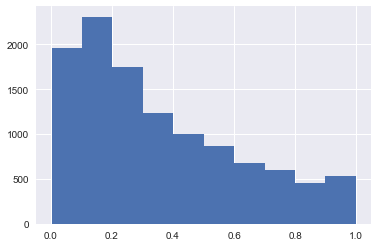

In [45]:
plt.hist(test_preds);

In [47]:
submission_df = pd.read_csv('../M/input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
submission_df['Pred'] = test_preds
submission_df.head()

,ID,Pred
0,2015_1107_1112,0.013930
1,2015_1107_1116,0.065822
2,2015_1107_1124,0.107454
3,2015_1107_1125,0.255442
4,2015_1107_1129,0.145515


In [57]:
now = datetime.datetime.strftime(datetime.datetime.now(), "%Y_%m_%d_%H_%M")
submission_df.to_csv('../output/submission_M_{}.csv'.format(now), index=False)